##установка

In [ ]:
! wget https://raw.githubusercontent.com/Russkova/diplom/main/data_preprocessing.py -O data_preprocessing.py
! wget https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/scaledsvd.py -O scaledsvd.py

! pip install lightfm
!apt-get install libsuitesparse-dev
!pip install scikit-sparse
! wget https://raw.githubusercontent.com/Russkova/diplom/main/hybrids.py -O hybrids.py

--2024-05-22 21:34:50--  https://raw.githubusercontent.com/Russkova/diplom/main/data_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11288 (11K) [text/plain]
Saving to: ‘data_preprocessing.py’

data_preprocessing. 100%[===================>]  11.02K  --.-KB/s    in 0s      

2024-05-22 21:34:51 (71.1 MB/s) - ‘data_preprocessing.py’ saved [11288/11288]

--2024-05-22 21:34:51--  https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/scaledsvd.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1507 (1.5K) [

In [ ]:
! pip install --upgrade git+https://github.com/Russkova/polara@main#egg=polara

  Cloning https://github.com/Russkova/polara (to revision main) to /tmp/pip-install-5ki98_bt/polara_a8fddb97ece74a0abbdaa28fafea6f5f
  Running command git clone --filter=blob:none --quiet https://github.com/Russkova/polara /tmp/pip-install-5ki98_bt/polara_a8fddb97ece74a0abbdaa28fafea6f5f
  Resolved https://github.com/Russkova/polara to commit f42942bef0c2c2c0b344c9e93164e2e799e7176c
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2-py3-none-any.whl size=86271 sha256=289fa56105ec9946eda603e738eb85d185a198e5834ee6e66f87dd85a4eed2be
  Stored in directory: /tmp/pip-ephem-wheel-cache-vv09pdxm/wheels/ce/05/37/5a9c8c1d28b55ab27441755eac459c8dae32bcf6592950c761
Successfully built polara


In [ ]:
! pip install ipypb

In [ ]:
! wget https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/data/meta_info_ml1m.csv -O meta_info_ml1m.csv
! wget https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/utils.py -O utils.py
!apt-get install libsuitesparse-dev
!pip install scikit-sparse
! wget https://github.com/Russkova/diplom/raw/main/ml-1m.zip -O ml-1m.zip

--2024-05-22 21:36:48--  https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/data/meta_info_ml1m.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432261 (422K) [text/plain]
Saving to: ‘meta_info_ml1m.csv’

meta_info_ml1m.csv  100%[===================>] 422.13K  --.-KB/s    in 0.03s   

2024-05-22 21:36:48 (13.0 MB/s) - ‘meta_info_ml1m.csv’ saved [432261/432261]

--2024-05-22 21:36:48--  https://raw.githubusercontent.com/evfro/recsys19_hybridsvd/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3773 (

In [ ]:
%env MKL_NUM_THREADS=16
%env OMP_NUM_THREADS=16

env: MKL_NUM_THREADS=16
env: OMP_NUM_THREADS=16


In [ ]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_config,
                                         set_config)

from hybrids import HybridSVD, HybridSVDColdStart
from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model,
                                SimilarityDataModel)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [ ]:
from polara.recommender import defaults
defaults.memory_hard_limit = 10

In [ ]:
seed = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подбор параметров

In [ ]:
data_labels = ['ML1M']
svd_ranks = {'ML1M': [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000}
hybridsvd_weights = [0.1, 0.3, 0.5, 0.7, 0.9]
topk_values = [1, 3, 10, 20, 30]
target_metric = 'mrr'
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)
all_data = [data_dict, similarities, sim_indices, meta_dict]
lbl = 'ML1M'

In [ ]:
from polara import get_movielens_data as get_ml_data
def get_movielens_data(path, fixes_path=None, meta_path=None, implicit=False, filter_data=None, filter_no_meta=False):
    ratings = get_ml_data(path, include_time=True)
    meta_info = None

    if implicit:
        ratings = ratings.query('rating>=4').assign(rating=1)

    if fixes_path is not None:
        id_fix = pd.read_csv(fixes_path)
        fix_col = id_fix.columns[0]
        ratings.movieid.replace(id_fix.set_index(fix_col).movieid, inplace=True)
        ratings = ratings.drop_duplicates()

    if meta_path is not None:
        meta_info = (pd.read_csv(meta_path, sep=';', na_filter=False).set_index('movieid')
                     .reindex(index=ratings['movieid'].unique(), fill_value=[]))
        meta_cols = meta_info.columns
        meta_info.loc[:, meta_cols] = (meta_info.loc[:, meta_cols]
                                       .applymap(lambda x: x.split(',') if x else []))

        if filter_data:
            for field, values in filter_data.items():
                meta_info.loc[:, field] = meta_info[field].apply(lambda x: [v for v in x if v not in values])

        if filter_no_meta:
            not_empty = meta_info.applymap(len).sum(axis=1) > 0
            if not not_empty.all():
                meta_info = meta_info.loc[not_empty]
                ratings = ratings.query(f'movieid in @meta_info.index')
    return ratings, meta_info

In [ ]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('/content/ml-1m.zip',
                                                    meta_path='/content/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [ ]:
data_dict[lbl]

,userid,movieid,rating,timestamp
0,1,1193,1,978300760
3,1,3408,1,978300275
4,1,2355,1,978824291
6,1,1287,1,978302039
7,1,2804,1,978300719
...,...,...,...,...
1000202,6040,1089,1,956704996
1000205,6040,1094,1,956704887
1000206,6040,562,1,956704746
1000207,6040,1096,1,956715648


In [ ]:
data_dict[lbl] = data_dict[lbl].sort_values(['userid', 'timestamp'], ascending=[True, True]).reset_index(drop=True)

In [ ]:
data_dict[lbl]


,userid,movieid,rating,timestamp
0,1,3186,1,978300019
1,1,1270,1,978300055
2,1,1721,1,978300055
3,1,1022,1,978300055
4,1,1836,1,978300172
...,...,...,...,...
573971,6040,3671,1,997454367
573972,6040,232,1,997454398
573973,6040,2917,1,997454429
573974,6040,1921,1,997454464


In [ ]:
data_dict[lbl]
data_dict[lbl] = data_dict[lbl].sort_values(['userid', 'timestamp'], ascending=[True, False])

test = data_dict[lbl].groupby('userid').head(1)

train = data_dict[lbl].drop(test.index)

print('Test dataset:')
print(test)

print('Train dataset:')
print(train)

Test dataset:
        userid  movieid  rating  timestamp
44           1       48       1  978824351
117          2     1544       1  978300174
154          3     2081       1  978298504
170          4     2951       1  978294282
254          5     2029       1  978246555
...        ...      ...     ...        ...
573541    6036     2140       1  956754710
573661    6037      968       1  956801840
573674    6038     1183       1  956717204
573761    6039      912       1  956758029
573975    6040     1221       1  998315055

[6038 rows x 4 columns]
Train dataset:
        userid  movieid  rating  timestamp
42           1     1566       1  978824330
43           1     1907       1  978824330
39           1     2355       1  978824291
40           1     2294       1  978824291
41           1      783       1  978824291
...        ...      ...     ...        ...
573768    6040     1961       1  956703977
573769    6040     2019       1  956703977
573766    6040      593       1  956703954


In [ ]:
train

,userid,movieid,rating,timestamp
32,1,1566,1,978824330
34,1,1907,1,978824330
4,1,2355,1,978824291
30,1,2294,1,978824291
35,1,783,1,978824291
...,...,...,...,...
1000007,6040,1961,1,956703977
1000192,6040,2019,1,956703977
999873,6040,593,1,956703954
1000153,6040,2384,1,956703954


In [ ]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [ ]:
from scipy.sparse import load_npz
file_name = '/content/drive/MyDrive/Colab Notebooks/similarity_matrix_subbota.npz'
loaded_matrix = load_npz(file_name)
similarities[lbl]['userid'] = loaded_matrix

In [ ]:

from scipy.sparse import eye, csr_matrix

rows = cols = 3522
matrix = eye(rows, cols, dtype=int, format='csr')

# Выводим информацию о матрице
print(f"Размер матрицы: {matrix.shape}")
print(f"Количество ненулевых элементов: {matrix.nnz}")

Размер матрицы: (3522, 3522)
Количество ненулевых элементов: 3522


In [ ]:
similarities[lbl]['movieid'] = matrix



In [ ]:
sim_indices['ML1M']['userid'] = data_dict['ML1M']['userid'].unique()

In [ ]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 0.028392958546280524


In [ ]:
train = train.sort_values(['userid', 'timestamp'], ascending=[True, True])


In [ ]:
def prepare_data_model_last_rating_hold(data_label, raw_data, similarities, sim_indices, item_meta, seed=0, feedback=None, custom_order='timestamp'):
    userid = 'userid'
    itemid = item_meta[data_label].index.name
    data_model = SimilarityDataModel(similarities[data_label],
                                     sim_indices[data_label],
                                     raw_data[data_label],
                                     userid, itemid,
                                     feedback=feedback,
                                     seed=seed)
    data_model.test_fold = 0
    data_model.test_ratio = 0
    data_model.holdout_size = 1
    data_model._custom_order  = custom_order
    data_model.random_holdout = False
    data_model.warm_start = False
    data_model.verbose = False
    data_model.prepare()
    return data_model

In [ ]:

def fine_tune_hybridsvd(model, ranks, weights, label, record_time=False):
    param_grid = [(w, r) for w in weights for r in reversed(list(sorted(ranks)))]
    param_names = ('features_weight', 'rank')
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores
    return model_config, model_scores


In [ ]:
config = {}
scores = {}
data_models = {}

In [ ]:
similarities[lbl]

{'userid': <6038x6038 sparse matrix of type '<class 'numpy.float32'>'
 	with 32414226 stored elements in Compressed Sparse Column format>,
 'movieid': <3522x3522 sparse matrix of type '<class 'numpy.int64'>'
 	with 3522 stored elements in Compressed Sparse Row format>}

In [ ]:
data_dict[lbl] = data_dict[lbl].sort_values(['userid', 'timestamp'], ascending=[True, False])
data = data_dict[lbl]

In [ ]:
data_dict['ML1M'] = train

In [ ]:
for label in track(data_labels):
    data_models[label] = prepare_data_model_last_rating_hold(label, *all_data, seed, custom_order='timestamp')
    config[label], scores[label] = fine_tune_hybridsvd(HybridSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       hybridsvd_weights,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 1/1 [25:08<25:08, 1508.17s/it]

           ML1M [█████████████████████████████████████████████] 100/100 [25:02<00:01, 15.02s/it]

/content/hybrids.py:121: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._cholesky[entity] = CholeskyFactor(cholesky_decomp(entity_similarity, beta=beta))
/content/hybrids.py:52: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._factor.cholesky_inplace(A, beta=beta)
/content/hybrids.py:52: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._factor.cholesky_inplace(A, beta=beta)
/content/hybrids.py:52: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._factor.cholesky_inplace(A, beta=beta)
/content/hybrids.py:52: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._factor.cholesky_inplace(A, beta=beta)


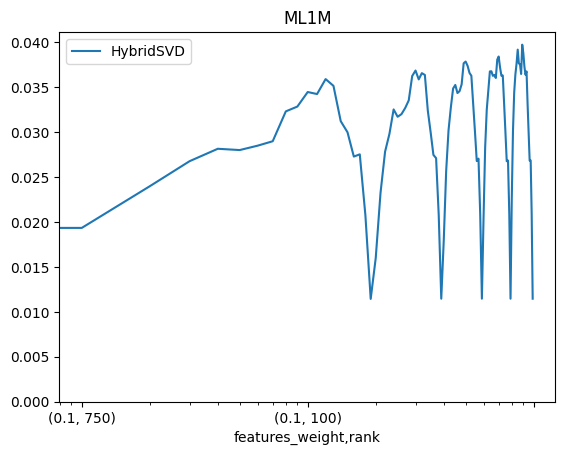

In [ ]:
report_results('rank', scores);

In [ ]:
scores

{'ML1M': {'HybridSVD': features_weight  rank
  0.1              1000    0.013257
                   750     0.019319
                   500     0.023956
                   400     0.026740
                   350     0.028122
                             ...   
  0.9              20      0.029920
                   15      0.026800
                   10      0.026833
                   5       0.020853
                   1       0.011445
  Name: HybridSVD, Length: 100, dtype: float64}}

In [ ]:
config

{'ML1M': {'HybridSVD': {'features_weight': 0.9, 'rank': 125}}}

In [ ]:
scores

{'ML1M': {'HybridSVD': features_weight  rank
  0.1              1000    0.018248
                   750     0.029739
                   500     0.044612
                   400     0.049050
                   350     0.056044
                             ...   
  0.9              20      0.093441
                   15      0.087447
                   10      0.078583
                   5       0.062556
                   1       0.039162
  Name: HybridSVD, Length: 100, dtype: float64}}

### Проверка метрик

In [ ]:
data_dict['ML1M'] = data

In [ ]:
data_models[label] = prepare_data_model_last_rating_hold(label, *all_data, seed,custom_order='timestamp' ) #вставить мою функцию препаре и свою олл дату

model_last = HybridSVD(data_models[label])

model_last.rank = 125
model_last.features_weight =0.9
model_last.evaluate()

HybridSVD model is not ready. Rebuilding.
Performing sparse Cholesky decomposition for movieid similarity
Cholesky decomposition computation time: 0.002s


/content/hybrids.py:121: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  self._cholesky[entity] = CholeskyFactor(cholesky_decomp(entity_similarity, beta=beta))


Performing sparse Cholesky decomposition for userid similarity
Cholesky decomposition computation time: 6.712s
HybridSVD training time: 40.643s
Building movieid projector for HybridSVD
    Solving triangular system: 0.004s
    Applying Cholesky factor: 0.005s


[Relevance(hr=0.10705999337089825),
 Ranking(arhr=0.037930233965202474, mrr=0.037930233965202474),
 Experience(coverage=0.2534811025859619),
 Hits(true_positive=646, false_positive=59694, true_negative=None, false_negative=5388)]